In [ ]:
!pip install transformers datasets
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from datasets import load_dataset
import string

vocab = list(string.ascii_lowercase) + ["[UNK]"]
label2id = {vocab[i]: i + 1 for i in range(len(vocab))}
id2label = {i + 1: vocab[i] for i in range(len(vocab))}

dataset = load_dataset("glue", "cola")


def process_sentence(sentence):
    # Remove spaces, commas, apostrophes, and convert to lowercase
    return "".join(sentence.replace(",", "").replace("'", "").split()).lower()


for split in dataset:
    dataset[split] = dataset[split].map(
        lambda example: {"sentence": process_sentence(example["sentence"])}
    )


def custom_tokenizer(sentence):
    tokens = []
    for char in sentence:
        if char.isalpha() and (char in label2id.keys()):
            tokens.append(label2id[char])
        else:
            tokens.append(label2id["[UNK]"])  # [UNK] token
    return tokens


for split in dataset:
    dataset[split] = dataset[split].map(
        lambda example: {"tokens": custom_tokenizer(example["sentence"])}
    )

print(dataset["train"][0])

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

{'sentence': 'ourfriendswontbuythisanalysisletalonethenextonewepropose.', 'label': 1, 'idx': 0, 'tokens': [15, 21, 18, 6, 18, 9, 5, 14, 4, 19, 23, 15, 14, 20, 2, 21, 25, 20, 8, 9, 19, 1, 14, 1, 12, 25, 19, 9, 19, 12, 5, 20, 1, 12, 15, 14, 5, 20, 8, 5, 14, 5, 24, 20, 15, 14, 5, 23, 5, 16, 18, 15, 16, 15, 19, 5, 27]}


In [ ]:
import torch


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
import numpy as np


def split(x):
    y = []
    z = []
    for i in range(1, len(x)):
        y.append(x[:i])
        z.append(x[i])
    return y, z


def pad_1d_tensors_with_fpad(tensor_list):
    # Find the maximum length among all tensors
    max_length = 128

    # Create a new list of tensors with the same length by padding with zeros
    padded_tensors = []
    for t in tensor_list:
        padding_length = max_length - t.shape[0]
        padded_tensor = torch.nn.functional.pad(
            t, (0, padding_length), mode="constant", value=0
        )
        padded_tensors.append(padded_tensor)

    return padded_tensors


mapper = np.eye(len(vocab))


def pre_process(tokens):
    input_data = []
    output_data = []
    for token in tokens:
        y, z = split(token)
        input_data += y
        output_data += z
    output_data = [mapper[x - 1] for x in output_data]

    for i in range(len(input_data)):
        input_data[i] = torch.tensor(np.array(input_data[i]))
    input_data = pad_1d_tensors_with_fpad(input_data)
    input_data1 = {"input_ids": input_data}
    return MyDataset(input_data1, output_data)

In [ ]:
train_data = pre_process(dataset["train"]["tokens"])
val_data = pre_process(dataset["validation"]["tokens"])

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.nn.functional import cross_entropy

repo_name = "/content/drive/MyDrive/models/output"
training_args = TrainingArguments(
    output_dir=repo_name,
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    seed=1,
    # logging & evaluation strategies
    logging_dir=f"{repo_name}/logs",
    logging_strategy="epoch",  # to get more information to TB
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    resume_from_checkpoint=repo_name,
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_true = labels

    best_threshold = None
    best_acc = -1

    # loop over threshold values and find the one that maximizes acc score
    for threshold in np.arange(0.1, 0.9, 0.1):
        y_pred = np.zeros(probs.shape, dtype=int)
        y_pred[np.where(probs >= threshold)] = 1
        acc = accuracy_score(y_true, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold

    # compute metrics using the best threshold
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= best_threshold)] = 1
    acc = accuracy_score(y_true, y_pred)
    perplexity = np.exp(
        cross_entropy(torch.Tensor(predictions), torch.Tensor(labels)).detach().numpy()
    )
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )

    return {
        "accuracy": acc,
        "perplexity": perplexity,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "best_threshold": best_threshold,
    }

In [ ]:
from transformers import AutoModelForSequenceClassification

model_name = "gpt2"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    problem_type="multi_label_classification",
    num_labels=len(vocab),
    id2label=id2label,
    label2id=label2id,
)
model.config.pad_token_id = 0

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
)

In [ ]:
! ls "/content/drive/MyDrive/models/output"

checkpoint-105132  checkpoint-87610  logs


In [ ]:
trainer.train(resume_from_checkpoint=repo_name + "checkpoint-105132")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-4-d47f5341ad6f>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Perplexity,Precision,Recall,F1,Best Threshold
5,0.101000,0.098715,0.324745,6.717052,0.520633,0.406895,0.442133,0.300000
6,0.099200,0.098122,0.332400,6.660977,0.520952,0.412094,0.446115,0.300000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-4-d47f5341ad6f>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=105132, training_loss=0.03337667101127927, metrics={'train_runtime': 13742.1262, 'train_samples_per_second': 122.402, 'train_steps_per_second': 7.65, 'total_flos': 1.0990387538126438e+17, 'train_loss': 0.03337667101127927, 'epoch': 6.0})

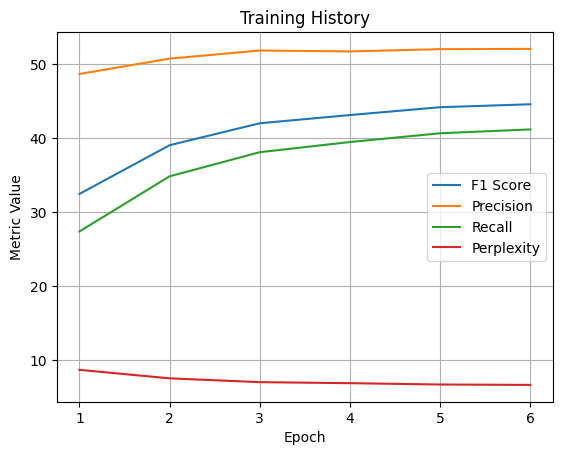

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the trainer_state.json file
with open(
    "/content/drive/MyDrive/models/output/checkpoint-105132/trainer_state.json", "r"
) as file:
    trainer_state = json.load(file)

# Extract the log history
log_history = trainer_state["log_history"]

# Initialize lists to store metric values for each epoch
epochs = []
f1_scores = []
precisions = []
recalls = []
perplexities = []

epoch = 0
for log in log_history:
    if (
        "eval_f1" in log
        and "eval_precision" in log
        and "eval_recall" in log
        and "eval_perplexity" in log
    ):
        epoch += 1
        epochs.append(epoch)
        f1_scores.append(100 * log["eval_f1"])
        precisions.append(100 * log["eval_precision"])
        recalls.append(100 * log["eval_recall"])
        perplexities.append(log["eval_perplexity"])

# Plot the metrics
plt.plot(epochs, f1_scores, label="F1 Score")
plt.plot(epochs, precisions, label="Precision")
plt.plot(epochs, recalls, label="Recall")
plt.plot(epochs, perplexities, label="Perplexity")

# Add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training History")
plt.legend()
plt.grid(True)
plt.show()